# Data Analysis

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

digits = load_digits()
X = digits.data
y = digits.target

# Check output range and type (entries are np.int64):
print("All outputs are integers in [0, 9]:")
print(np.all([((type(y[i]) == np.int64) & (y[i] > -1) & (y[i] < 10)) for i in range(0,len(y))]))

# Check input range and type (entries are np.float64):
print("All inputs are vectors of integers in [0, 16]:")
print(np.all([((np.max(abs(X[i,j] - np.round(X[i,j]))) == 0) & (type(X[i,j]) == np.float64) & (X[i,j] > -1) & (X[i,j] < 17)) for i in range(0, np.size(X,0)) for j in range(0, np.size(X,1))]))

# Check for duplicate inputs:
print("All inputs are unique:")
unique_X = np.unique(X, axis=0)
print(np.size(X,0) == np.size(unique_X,0))

All outputs are integers in [0, 9]:
True
All inputs are vectors of integers in [0, 16]:
True
All inputs are unique:
True


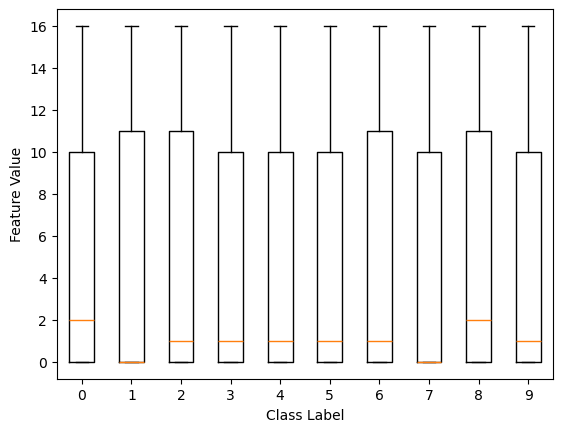

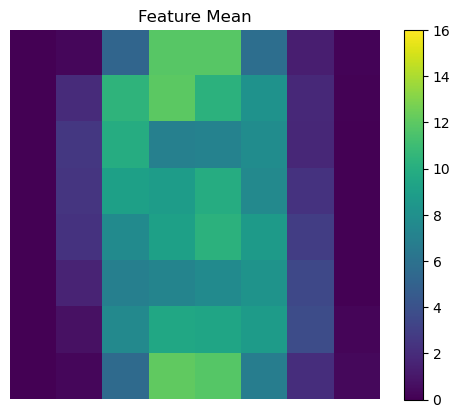

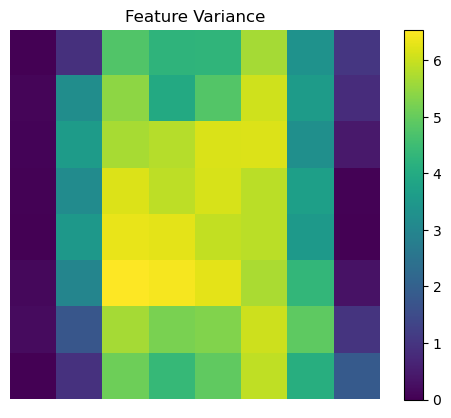

Maximum standard deviation occurs for feature:
5.225493143981047


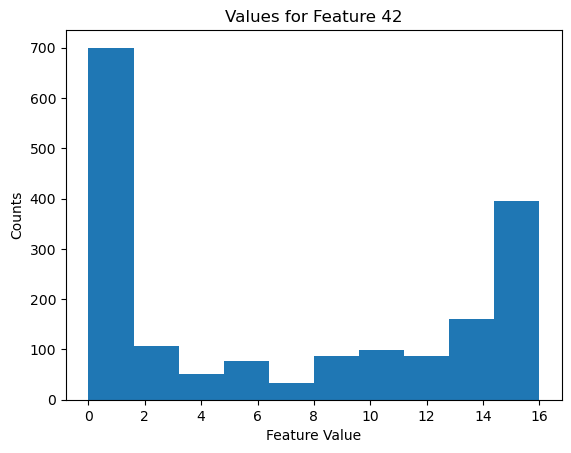

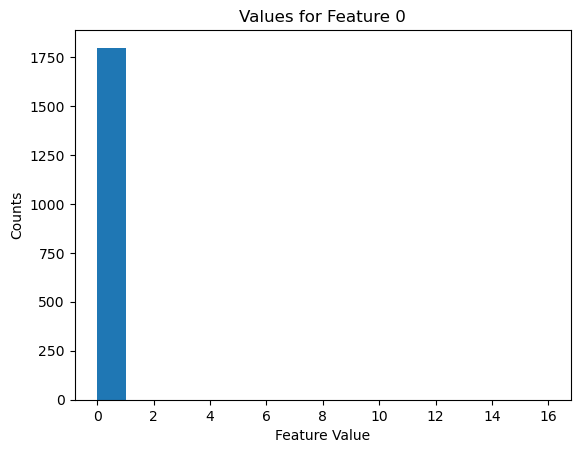

/Users/mathiasdufresne-piche/miniconda3/envs/ECSE_551/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/mathiasdufresne-piche/miniconda3/envs/ECSE_551/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


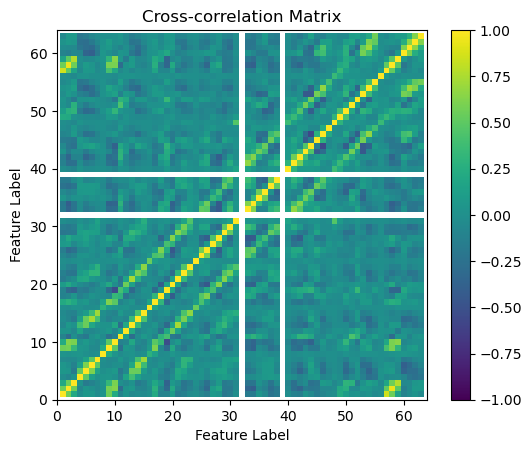

In [ ]:
# Now, we perform brief statistical analysis on the data

# Box plots of feature values (all) for each class
sorted_X = [np.ravel(X[y == i,:]) for i in range(0,10)]
plt.boxplot(sorted_X, tick_labels=[str(i) for i in range(0,10)])
plt.xlabel("Class Label")
plt.ylabel("Feature Value")
plt.show()

# Mean for each feature (shown as 8x8 image)
plt.imshow(np.reshape(np.mean(X, axis=0), (8,8)), vmin=0, vmax=16)
plt.axis('off')
plt.colorbar()
plt.title("Feature Mean")
plt.show()

# Variance for each feature (shown as 8x8 image)
plt.imshow(np.reshape(np.std(X, axis=0), (8,8)))
plt.axis('off')
plt.colorbar()
plt.title("Feature Variance")
plt.show()

# Histogram for one of the "center" features (we select the pixel (3,4))
plt.hist(X[:,42])
plt.xlabel("Feature Value")
plt.ylabel("Counts")
plt.title("Values for Feature 42")
plt.show()

# Histogram for one of the "side" features (we select the pixel (0,0))
plt.hist(X[:,0], np.array([i for i in range(0, 17)]))
plt.xlabel("Feature Value")
plt.ylabel("Counts")
plt.title("Values for Feature 0")
plt.show()

# Correlation coefficient (missing pixels have a standard deviation of 0)
corr = np.corrcoef(X.T)
plt.imshow(corr, vmin=-1, vmax=1)
plt.colorbar()
plt.title("Cross-correlation Matrix")
plt.xlim([0, 64])
plt.ylim([0, 64])
plt.xlabel("Feature Label")
plt.ylabel("Feature Label")
plt.show()



# Classification Models

In [1]:
# Multiclass SVM class

class MulticlassSVM:
    def __init__(self, learning_rate, lambda_param, n_iters):
        self.learning_rate = learning_rate
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.Nfeat = 64
        self.Nclass = 10
        self.w = np.zeros((self.Nfeat+1, self.Nclass)) # All SVM parameters, each column corresponds to one digit, w[0] is the bias

    def fit(self, X, y):
        ytilde = np.zeros(np.shape(y)) # stores transformed inputs, (N,) array
        Linf_grad = np.zeros((self.Nclass,)) # stores L\infty norm of gradient for each class when gradient descent terminates

        for digit in range(0,self.Nclass):
            ytilde[y==digit] = 1.0
            ytilde[y!=digit] = -1.0

            # gradient descent
            w = np.ones((np.size(X,1)+1,))
            grad = np.zeros((np.size(X,1)+1,))

            for i in range(0, self.n_iters):
                # compute gradient
                mask = (ytilde * (X @ w[1:self.Nfeat+1] + w[0])) < 1
                grad[1:self.Nfeat+1] = w[1:self.Nfeat+1] - self.lambda_param * np.sum(X[mask,:] * ytilde[mask,None], axis=0)
                grad[0] = - self.lambda_param * np.sum(ytilde[mask])

                # gradient step
                w = w - self.learning_rate * grad
            
            self.w[:, digit] = np.ravel(w) / np.sqrt(np.sum(w[1:self.Nfeat+1] ** 2)) # normalize and update weights
            Linf_grad[digit] = np.max(np.abs(grad))
        
        self.Linf_grad = Linf_grad

    def predict(self, X):
        if len(np.shape(X)) == 1:
            return np.argmax(X @ self.w[1:self.Nfeat+1,:] + self.w[0,:])
        elif len(np.shape(X)) == 2:
            return np.argmax(X @ self.w[1:self.Nfeat+1,:] + self.w[0,:][None,:], axis=1)


In [ ]:
# Training and testing the SVM

# Training and testing sets
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=42)
Xtrain = Xtrain / 16 # We normalize
Xtest = Xtest / 16

In [ ]:
# We perform cross validation to select the best \lambda and learning rate

# We re-split the testing data set for these purposes
Xtrain1, Xtrain2, ytrain1, ytrain2 = train_test_split(Xtrain, ytrain, test_size=0.3, random_state=42)

lambda_val = np.linspace(0,3.0, 15)
learning_rate =  2.0 ** (-np.arange(2,15))
N = 5000 # fixed number of iterations

ER = np.zeros((len(lambda_val), len(learning_rate)))

for i in range(0, len(lambda_val)):
    for j in range(0, len(learning_rate)):
        my_SVM = MulticlassSVM(learning_rate[j], lambda_val[i], N)
        my_SVM.fit(Xtrain1, ytrain1)
        ER[i,j] = np.sum(my_SVM.predict(Xtrain2) != ytrain2) / np.size(ytrain2)
        

/var/folders/lv/pl21j70d4051sw3z9247p6kw0000gn/T/ipykernel_21196/3383114765.py:33: RuntimeWarning: divide by zero encountered in divide
  self.w[:, digit] = np.ravel(w) / np.sqrt(np.sum(w[1:self.Nfeat+1] ** 2)) # normalize and update weights
/var/folders/lv/pl21j70d4051sw3z9247p6kw0000gn/T/ipykernel_21196/3383114765.py:42: RuntimeWarning: invalid value encountered in matmul
  return np.argmax(X @ self.w[1:self.Nfeat+1,:] + self.w[0,:][None,:], axis=1)


lambda:
0.8571428571428571
learning rate:
0.001953125
0.03439153439153439


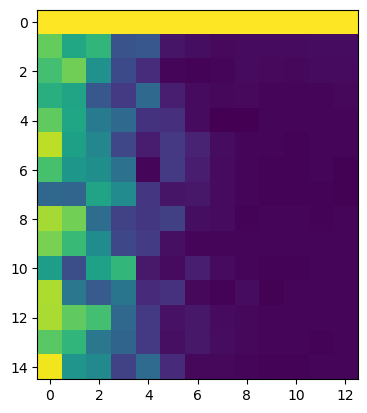

In [ ]:
# Select best parameters
i, j = np.unravel_index(np.argmin(ER), np.shape(ER))
print("lambda:")
print(lambda_val[i])
print("learning rate:")
print(learning_rate[j])
print(ER[i,j])

plt.imshow(ER)
plt.show()


In [145]:
# Final training
my_SVM = MulticlassSVM(0.0009765625, 1.9285714285714284, 5000)
my_SVM.fit(Xtrain, ytrain)

In [146]:
# Test model
print("Error rate is:")
print(np.sum(my_SVM.predict(Xtest) != ytest) / np.size(ytest))


Error rate is:
0.03888888888888889


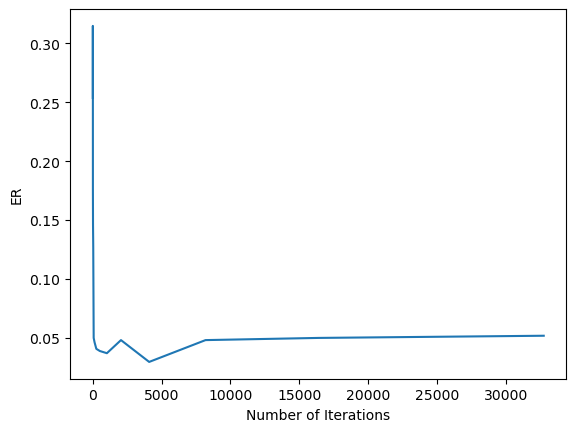

In [151]:
# Evaluate impact of number of iterations
N = 2 ** np.arange(1, 16)
ER = np.zeros(np.shape(N))

for i in range(0, len(N)):
    my_SVM = MulticlassSVM(0.0009765625, 1.9285714285714284, N[i])
    my_SVM.fit(Xtrain1, ytrain1)
    ER[i] = np.sum(my_SVM.predict(Xtest) != ytest) / np.size(ytest)

plt.plot(N, ER)
plt.ylabel("ER")
plt.xlabel("Number of Iterations")
plt.show()

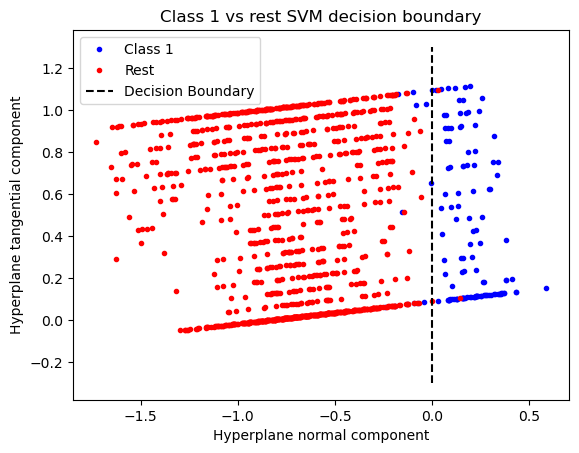

Training Error Rate for Class 1
0.011933174224343675


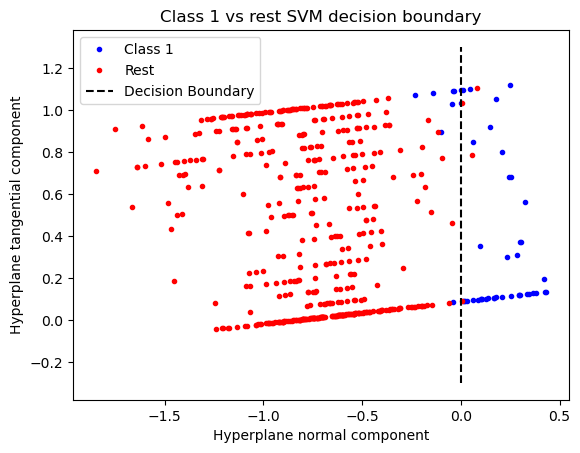

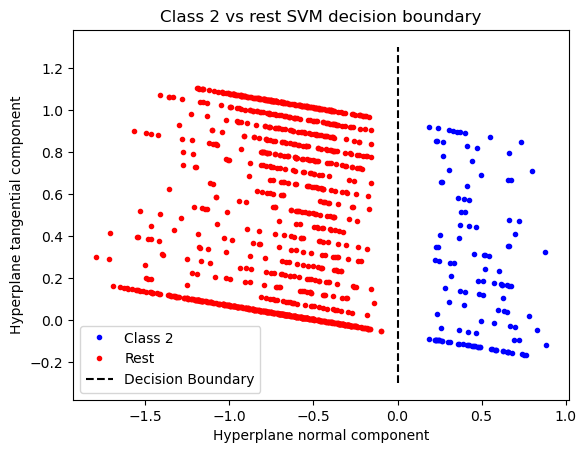

Training Error Rate for Class 2
0.0


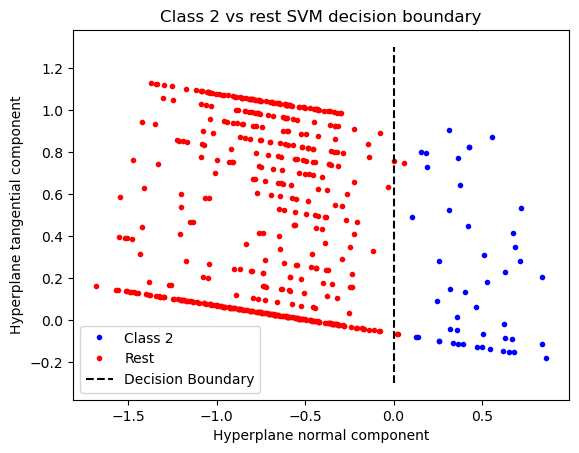

In [132]:
# Function to plot decision boundary:
def decision_bd(digit, feature, my_SVM, X, y):
    # Determine hyperplane unit normal and offset vectors
    n = my_SVM.w[1:65,digit]
    norm_n = np.linalg.norm(n)
    n = n / norm_n # this is our unit normal vector
    offset = -my_SVM.w[0,digit] / norm_n * n

    # We figure out our other basis vector
    vf = np.zeros((64,))
    vf[feature] = 1.0
    vf = vf - np.dot(n, vf) * n # orthogonalize
    vf = vf / np.linalg.norm(vf) # this is our unit tangential vector

    # We build the projection operator
    Proj = np.vstack((n, vf)).T

    # Project and plot
    Xtrainproj = (X - offset[None,:]) @ Proj
    Xtrainproj_true = Xtrainproj[y == digit,:]
    Xtrainproj_false = Xtrainproj[y != digit,:]
    
    plt.plot(Xtrainproj_true[:,0], Xtrainproj_true[:,1], 'b.')
    plt.plot(Xtrainproj_false[:,0], Xtrainproj_false[:,1], 'r.')
    plt.plot([0.0, 0.0], [-0.3, 1.3], 'k--')
    plt.xlabel("Hyperplane normal component")
    plt.ylabel("Hyperplane tangential component")
    plt.title("Class " + str(digit) + " vs rest SVM decision boundary")
    plt.legend(["Class " + str(digit), "Rest", "Decision Boundary"])
    plt.show()

# For class 1
decision_bd(1, 42, my_SVM, Xtrain, ytrain) # For training
print("Training Error Rate for Class 1")
print(np.sum((Xtrain @ my_SVM.w[1:65,1] + my_SVM.w[0,1] > 0) != (ytrain == 1)) / np.size(ytrain))
decision_bd(1, 42, my_SVM, Xtest, ytest) # For testing


# For class 2
decision_bd(2, 42, my_SVM, Xtrain, ytrain) # for training
print("Training Error Rate for Class 2") # for testing
print(np.sum((Xtrain @ my_SVM.w[1:65,2] + my_SVM.w[0,2] > 0) != (ytrain == 2)) / np.size(ytrain))
decision_bd(2, 42, my_SVM, Xtest, ytest)



In [152]:
# MLP class

# Assume only one hidden layer??

class MLP:
    def __init__(self, input_sz, hidden_sz, output_sz, learning_rate):
        self.input_sz = input_sz
        self.hidden_sz = hidden_sz
        self.output_s = output_sz
        self.learning_rate = learning_rate
        self.Nclass = 10
        self.Nfeat = 64

        rng = np.random.default_rng(seed=42)

        self.W1 = rng.random((hidden_sz, input_sz)) / input_sz
        self.B1 = rng.random((hidden_sz,)) / input_sz
        self.W2 = rng.random((output_sz, hidden_sz)) / hidden_sz
        self.B2 = rng.random((output_sz,)) / hidden_sz
    
    def relu(self, z):
        f = np.zeros(np.shape(z))
        mask = z > 0
        f[mask] = z[mask]
        return f
    
    def relu_derivative(self, z):
        df = np.zeros(np.shape(z))
        df[z > 0] = 1.0
        return df
    
    def softmax(self, z):
        x = np.exp(z)
        if len(np.shape(z)) == 1:
            return x / np.sum(x)
        elif len(np.shape(z)) == 2: # for matrices, softmax is computed row-wise
            return x / np.sum(x, axis=1)[:,None]
    
    def mult_softmax_Jacobian(self, z, x): # multiplication of x by softmax Jacobian at z
        s = self.softmax(z)
        return -np.dot(s,x) * s + s * x # softmax has symmetric jacobian

    def fit(self, X, y, epochs):
        Ntrain = np.size(X,0)

        W1 = self.W1
        B1 = self.B1
        W2 = self.W2
        B2 = self.B2

        # pre-allocation
        Loss = np.zeros((epochs,))
        gradW1 = np.zeros(np.shape(W1))
        gradB1 = np.zeros(np.shape(B1))
        gradW2 = np.zeros(np.shape(W2))
        gradB2 = np.zeros(np.shape(B2))

        for i in range(0, epochs):
            # Compute grad by looping over all training samples
            gradW1[:] = 0.0
            gradB1[:] = 0.0
            gradW2[:] = 0.0
            gradB2[:] = 0.0

            for itrain in range(0, Ntrain):
                # forward pass
                x1 = W1 @ X[itrain,:] + B1  # x1 = W1 @ X + B1
                x2 = self.relu(x1)          # x2 = ReLu(x1)
                x3 = W2 @ x2 + B2           # x3 = W2 @ x2 + B2
                x4 = self.softmax(x3)       # x4 = softmax(x3)
                Loss[i] += 0.5 * np.sum((x4 - ytrain[itrain]) ** 2)

                # backward pass
                dL_dx3 = self.mult_softmax_Jacobian(x3, x4 - y[itrain,:]) # \partial L / \partial x3
                gradW2 += np.outer(dL_dx3, x2) # shortcut to reshape gradient as a matrix
                gradB2 += dL_dx3 # since Jacobian \partial x3 / \partial B1 is identity
                dL_dx1 = (dL_dx3 @ W2) * self.relu_derivative(x2) # since Jacobian \partial x2 / \partial x1 is diagonal
                gradW1 += np.outer(dL_dx1, X[itrain, :])
                gradB1 += dL_dx1
            
            # use gradient descent to update param
            W1 -= self.learning_rate * gradW1
            B1 -= self.learning_rate * gradB1
            W2 -= self.learning_rate * gradW2
            B2 -= self.learning_rate * gradB2
        
        self.W1 = W1
        self.B1 = B1
        self.W2 = W2
        self.B2 = B2
        self.Loss = Loss
    
    def predict_proba(self, X):
        if len(np.shape(X)) == 1:
            return self.softmax(self.W2 @ self.relu(self.W1 @ X + self.B1) + self.B2)
        elif len(np.shape(X)) == 2:
            return self.softmax((self.W2 @ self.relu(self.W1 @ X.T + self.B1[:,None]) + self.B2[:,None]).T)

    def predict(self, X):
        if len(np.shape(X)) == 1:
            return np.argmax(self.predict_proba(X))
        elif len(np.shape(X)) == 2:
            return np.argmax(self.predict_proba(X), axis=1)

In [153]:
# Testing MLP

# Training and testing sets

# We split and normalize
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=42)
Xtrain = Xtrain / 16
Xtest = Xtest / 16

# We encode classes using binary vectors (could have used sklearn, but this one is easy to do)
ytrain_enc = np.zeros((len(ytrain), 10))
index = range(0,len(ytrain))
ytrain_enc[index, ytrain[index]] = 1.0

In [169]:
# We perform cross-validation to select the best number of hidden units and the learning rate
Xtrain1, Xtrain2, ytrain1, ytrain2 = train_test_split(Xtrain, ytrain, test_size=0.3, random_state=42)
ytrain_enc1 = np.zeros((len(ytrain1), 10))
index = range(0,len(ytrain1))
ytrain_enc1[index, ytrain1[index]] = 1.0

learning_rate = np.array([0.1, 0.01, 0.001, 0.0001])
Nhidden = np.array([2, 4, 8, 16, 32, 64, 128])

epochs = 1000 # fixed number of iterations

ER = np.zeros((len(Nhidden), len(learning_rate)))

for i in range(0, len(Nhidden)):
    for j in range(0, len(learning_rate)):
        my_MLP = MLP(64, Nhidden[i], 10, learning_rate[j])
        my_MLP.fit(Xtrain1, ytrain_enc1, epochs)
        ER[i,j] = np.sum(my_MLP.predict(Xtrain2) != ytrain2) / np.size(ytrain2)


/var/folders/lv/pl21j70d4051sw3z9247p6kw0000gn/T/ipykernel_21196/2225951789.py:33: RuntimeWarning: overflow encountered in exp
  x = np.exp(z)
/var/folders/lv/pl21j70d4051sw3z9247p6kw0000gn/T/ipykernel_21196/2225951789.py:35: RuntimeWarning: invalid value encountered in divide
  return x / np.sum(x)


lambda:
32
learning rate:
0.001
0.037037037037037035


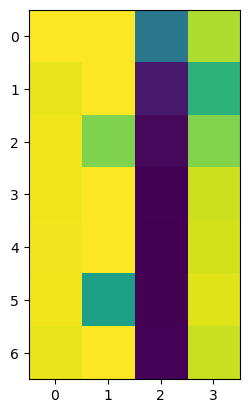

In [171]:
# Select best combination:

i, j = np.unravel_index(np.argmin(ER), np.shape(ER))
print("lambda:")
print(Nhidden[i])
print("learning rate:")
print(learning_rate[j])
print(ER[i,j])

plt.imshow(ER)
plt.show()

In [173]:
# Final training
my_MLP = MLP(64, 32, 10, 0.001)
my_MLP.fit(Xtrain, ytrain_enc, 1000)

In [ ]:
# Test model
print(np.sum(ytest != my_MLP.predict(Xtest)) / np.size(ytest))

0.03333333333333333


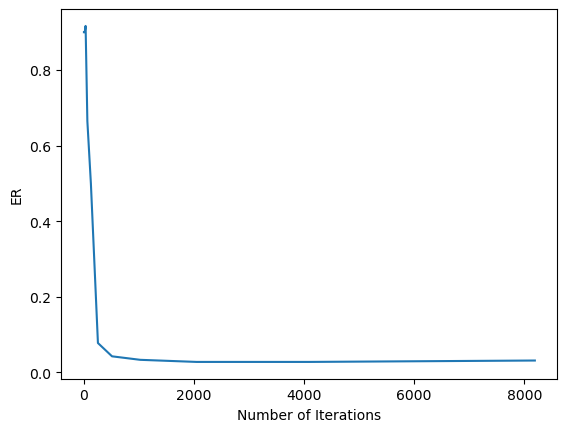

In [180]:
# Evaluate impact of number of epochs
epochs = 2 ** np.arange(1, 14)
ER = np.zeros(np.shape(epochs))

for i in range(0, len(epochs)):
    my_MLP = MLP(64, 32, 10, 0.001)
    my_MLP.fit(Xtrain, ytrain_enc, epochs[i])
    ER[i] = np.sum(my_MLP.predict(Xtest) != ytest) / np.size(ytest)

plt.plot(epochs, ER)
plt.ylabel("ER")
plt.xlabel("Number of Iterations")
plt.show()